# Individual transition matrices
In this notebook we investigate the individual matrices. As we saw earlier the sessions of length one was dominating the data set. Therefore we will here disregard these sessions, in the hope that the patterns of intrest become more prominent.

# Import

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import ast
pd.options.plotting.backend = "plotly"
import plotly.express as px
# from chart_studio import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.subplots as sp
pd.options.display.max_colwidth = None
pd.set_option('display.max_rows', 70)
from pandas.plotting import table 
import nltk
import seaborn as sns
%matplotlib inline
import random
import matplotlib.gridspec as grid
import matplotlib
from sklearn.decomposition import NMF

# Data preparation

In [2]:
data=pd.read_csv("sorted_coded_session_293s_merged.csv")
data['start']=data.groupby('user_id').session.shift(1)!=data.session
data['end']=data.groupby('user_id').session.shift(-1)!=data.session

In [3]:
data=data.drop(columns=['time_spend','app_code','sequence_number','sequence_Start_time','sequence_end_time'])

## Remove sessions of length one

In [4]:
data=data.merge(data.groupby(['user_id','session']).agg({'package_name':'size'}).rename(columns={'package_name':'session_length'}).reset_index(),on=['user_id','session'])

In [5]:
data=data[data.session_length>1]

After removing the sessions of length one, we will take a look at the remaining users.

In [7]:
data.user_id.nunique()

10000

We see that all users still remain in the data set. Next we see if all users still have enough information left to meaningfully analys their use patterns.

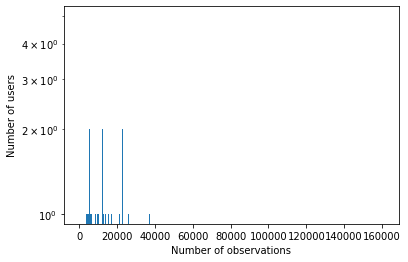

In [40]:
user_observations=data.groupby(['user_id']).size().reset_index().sort_values(0).groupby([0]).size()
plt.bar(user_observations.index,user_observations.values)
plt.yscale('log')
plt.xlabel('Number of observations')
plt.ylabel('Number of users')
plt.show()

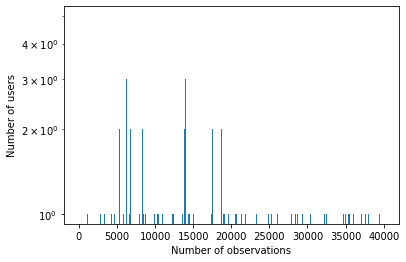

In [45]:
plt.bar(user_observations.loc[:40000].index,user_observations.loc[:40000].values)
plt.yscale('log')
plt.xlabel('Number of observations')
plt.ylabel('Number of users')
plt.show()

We then take a look at the number of sessions for each user.

In [51]:
user_sessions=data.groupby(['user_id']).session.nunique().reset_index().sort_values('session').groupby(['session']).size()

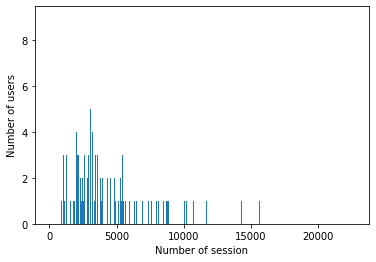

In [55]:
plt.bar(user_sessions.index,user_sessions.values)
plt.xlabel('Number of session')
plt.ylabel('Number of users')
plt.show()

In [59]:
data.groupby(['user_id']).session.nunique().reset_index().session.describe()

count    10000.000000
mean      4489.404600
std       2934.361661
min         25.000000
25%       2449.000000
50%       3740.500000
75%       5706.000000
max      22676.000000
Name: session, dtype: float64

While we see that some of the users has a low number of sessions, the minimum of 25 could potentially still be enough to show case patterns in that users usage.

# Calculating transition matrices

In [8]:
data_individual_app_count = data.groupby(['user_id','package_name'])\
                            .agg({'session':'size'})\
                            .rename(columns={'session':'app_count'})

In [9]:
individual_start_count=data.groupby(['user_id']).start.sum().reset_index()#,columns=['app_count'],index=['user_id','start'])
individual_start_count['package_name']='start'
individual_start_count=individual_start_count.rename(columns={'start':'app_count'})

In [10]:
data_individual_app_count=data_individual_app_count.append(individual_start_count.set_index(['user_id','package_name']))

In [11]:
data['next_app'] = data.groupby(['user_id','session']).package_name.shift(-1).fillna("end")

In [12]:
data_individual_next_app_count=data.groupby(['user_id','package_name','next_app'])\
                            .agg({'session':'size'})\
                            .rename(columns = {'session':'next_count'})

In [13]:
df_individual_numerator = data_individual_next_app_count.reset_index()
data_individual_app_count=data_individual_app_count.reset_index()

In [14]:
df_transition = df_individual_numerator.merge(data_individual_app_count, on=['user_id','package_name'])
df_transition['probability'] =df_transition.next_count/df_transition.app_count*100
df_transition.drop(['next_count', 'app_count'], axis=1, inplace=True)

In [15]:
df_transition.to_csv("individual_transition_matrices_min_length_2.csv")

In [37]:
df_transition=pd.read_csv("individual_transition_matrices_min_length_2.csv")

# NMF
Now that we have all of the transition matrices, we can try and use NMF for comparing them. However first we need to get them on a common common vector representation. However merging all the transition matrices, to make sure that all of the transions are there for all of the user, is slow an memory consuming. Therefore we look only at a small subset of users.

In [17]:
user_transition_matrices=df_transition.groupby('user_id')

In [141]:
full_individual_transitions=user_transition_matrices.get_group(0).drop(columns=['user_id'])

In [142]:
full_individual_transitions

,package_name,next_app,probability
0,air.ca.udesignit.kitchen,com.facebook.katana,25.000000
1,air.ca.udesignit.kitchen,com.google.android.youtube,25.000000
2,air.ca.udesignit.kitchen,com.sonyericsson.android.socialphonebook,25.000000
3,air.ca.udesignit.kitchen,com.viber.voip,25.000000
4,bbc.mobile.weather,bg.abv.andro.emailapp,3.092784
...,...,...,...
772,falcofinder.android.fce,end,100.000000
773,flv.mobile.android,com.android.chrome,100.000000
774,net.zedge.android,com.google.android.apps.translate,100.000000
775,subu.cambridgedictionary,com.android.chrome,100.000000


In [129]:
test=full_individual_transitions.merge(user_transition_matrices.get_group(1).drop(columns=['user_id']),on=['package_name','next_app'],how='outer',suffixes=('',i))

In [140]:
full_individual_transitions.drop(columns=['user_id']).merge(user_transition_matrices.get_group(1).drop(columns=['user_id']),on=['package_name','next_app'],how='outer',suffixes=('',i)).dropna()

,package_name,next_app,probability,probability29
51,com.adobe.reader,com.facebook.katana,19.531250,25.000000
65,com.adobe.reader,com.sonyericsson.conversations,1.562500,25.000000
70,com.alibaba.aliexpresshd,end,100.000000,20.161290
90,com.android.chrome,com.adobe.reader,1.408451,0.155400
93,com.android.chrome,com.android.incallui,1.220657,0.077700
...,...,...,...,...
665,com.sonymobile.entrance,end,12.500000,17.073171
666,com.sonymobile.moviecreator.rmm,com.android.chrome,5.000000,8.108108
667,com.sonymobile.moviecreator.rmm,com.facebook.katana,35.000000,24.324324
672,com.sonymobile.moviecreator.rmm,com.sonyericsson.album,10.000000,2.702703


In [144]:
for i in range(1,30):
    full_individual_transitions=full_individual_transitions.merge(user_transition_matrices.get_group(i).drop(columns=['user_id']),on=['package_name','next_app'],how='outer',suffixes=('',i))

In [145]:
full_individual_transitions=full_individual_transitions.fillna(0)

In [146]:
full_individual_transitions

,package_name,next_app,probability,probability1,probability2,probability3,probability4,probability5,probability6,probability7,...,probability20,probability21,probability22,probability23,probability24,probability25,probability26,probability27,probability28,probability29
0,air.ca.udesignit.kitchen,com.facebook.katana,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,air.ca.udesignit.kitchen,com.google.android.youtube,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,air.ca.udesignit.kitchen,com.sonyericsson.android.socialphonebook,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,air.ca.udesignit.kitchen,com.viber.voip,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,bbc.mobile.weather,bg.abv.andro.emailapp,3.092784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14426,org.zwanoo.android.speedtest,com.rightmove.android,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.142857
14427,org.zwanoo.android.speedtest,com.sonyericsson.conversations,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.285714
14428,org.zwanoo.android.speedtest,end,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.428571
14429,uk.co.travelrepublic.travelrepublic,com.android.chrome,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.666667


In [147]:
print("Number of zero elements:",(full_individual_transitions==0).values.sum()/(full_individual_transitions.shape[0]*full_individual_transitions.shape[1])*100)

Number of zero elements: 88.79170708890582


We now have a very spars matrix representing the transion matrices for the first 30 users. We can now perform NMF.

In [148]:
X=full_individual_transitions.drop(columns=["package_name","next_app"])

In [149]:
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [150]:
W=pd.DataFrame(W)

In [151]:
W

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.047706,0.0,0.0,0.025280,6.233841,0.187157,0.0,0.257530,0.211127,0.0,0.0,0.000000,0.0,0.0,0.039767,0.0,0.001033,0.0
1,0.0,0.0,0.047706,0.0,0.0,0.025280,6.233841,0.187157,0.0,0.257530,0.211127,0.0,0.0,0.000000,0.0,0.0,0.039767,0.0,0.001033,0.0
2,0.0,0.0,0.047706,0.0,0.0,0.025280,6.233841,0.187157,0.0,0.257530,0.211127,0.0,0.0,0.000000,0.0,0.0,0.039767,0.0,0.001033,0.0
3,0.0,0.0,0.047706,0.0,0.0,0.025280,6.233841,0.187157,0.0,0.257530,0.211127,0.0,0.0,0.000000,0.0,0.0,0.039767,0.0,0.001033,0.0
4,0.0,0.0,0.005902,0.0,0.0,0.003127,0.771197,0.023153,0.0,0.031859,0.026119,0.0,0.0,0.000000,0.0,0.0,0.004920,0.0,0.000128,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14426,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.076607,0.0,0.0,0.000000,0.0,0.000000,0.0
14427,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.153214,0.0,0.0,0.000000,0.0,0.000000,0.0
14428,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,3.229821,0.0,0.0,0.000000,0.0,0.000000,0.0
14429,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,10.048332,0.0,0.0,0.000000,0.0,0.000000,0.0


We try to take a look at which transitions are the most dominant for factor one.

In [169]:
full_individual_transitions.loc[W[0][W[0].isin(W[0].nlargest(20))].index]

,package_name,next_app,probability,probability1,probability2,probability3,probability4,probability5,probability6,probability7,...,probability20,probability21,probability22,probability23,probability24,probability25,probability26,probability27,probability28,probability29
996,com.audible.application,end,0.0,33.333333,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,50.0,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0
1080,com.dropbox.android,end,0.0,15.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,25.0,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0
1674,com.google.samples.apps.cardboarddemo,com.android.chrome,0.0,25.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0
3013,com.google.android.music,end,0.0,0.000000,0.0,35.507246,53.211009,0.0,0.0,0.0,...,0.0,0.0,0.0,50.000000,0.0,0.0,0.0,0.0,0.0,0.0
11698,com.berad.areffectdragons,com.sonymobile.areffect.japanese_theme,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0
11775,com.disneydigitalbooks.disneycolorandplay_goo,end,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,66.666667,0.0,0.0,0.0,0.0,0.0,0.0
11776,com.doodlejoy.studio.kidsdoojoy,com.whatsapp,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,50.000000,0.0,0.0,0.0,0.0,0.0,0.0
11777,com.doodlejoy.studio.kidsdoojoy,end,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,50.000000,0.0,0.0,0.0,0.0,0.0,0.0
11783,com.epicactiononline.ffxv.ane,com.android.chrome,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,50.000000,0.0,0.0,0.0,0.0,0.0,0.0
11784,com.epicactiononline.ffxv.ane,end,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,50.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
(W[0]>0).sum()

1918

In [167]:
H.loc[0,:]

0     0.000000
1     0.000000
2     0.008281
3     0.007760
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.006381
10    0.000000
11    0.002030
12    0.013262
13    0.000000
14    0.000000
15    0.001221
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.400906
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
Name: 0, dtype: float64

While the above weights show that factor 0, especially captures properties of especially one user (user 23),but also ta few others, it is still not clear what transitions are important for each of these user as, there are quit a lot of influencial transition.

In [163]:
H=pd.DataFrame(H)
H

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.000000,0.008281,0.007760,0.000000,0.000000,0.000000,0.000000,0.000000,0.006381,...,0.000000,0.000000,0.000000,0.400906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.005585,0.000000,0.000000,0.000000,0.003259,0.000000,0.000000,0.006204,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.018897,0.000000,0.049339,0.087765,0.000000,0.009363,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.406878,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.776413,0.000000,0.000000,0.219528,0.818032,0.000000,0.000000,0.825670,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.056657,0.000000,0.022309,0.000000,0.000000,0.000000,0.092027,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.320265,0.000000,0.000000
5,0.016333,2.980451,0.004570,0.000000,0.000000,0.019982,0.000000,0.000000,0.000000,0.039661,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1.547715,0.000000,0.000000,0.000000,0.000000,0.130310,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.942949,0.000000
7,0.030449,0.000000,0.016465,0.040160,0.000000,0.021542,0.000000,0.000000,1.541379,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.030682,1.298296,0.000000,0.760448,0.298869,0.000000,0.000000,0.013847,...,0.000000,0.000000,0.000000,0.000000,2.045528,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.059614,0.000000,0.000000,0.014904,0.000000,0.017138,0.000000,0.000000,0.000000,0.003878,...,0.000000,0.000000,1.860015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Illustration
The earlier illustraion trying to highlight the highest transition probabilities was confusing. Here we therefore try other approaches to see if they give a similar overview.

## Top 10 probabilites
In this section we try to highlight the top 10 highest transition proabilities for a subset of users. However first we must filter out packages which only occure ones, as they automaticly obtain a misleading 100 percent transition proability.

In [10]:
df_transition_without_ones=df_transition_without_ones[df_transition_without_ones.app_count>1]

In [13]:
top_10_individual_transitions=df_transition_without_ones.loc[df_transition_without_ones.groupby(['user_id']).probability.nlargest(10).reset_index().level_1.values]

In [18]:
top_10_individual_transitions=top_10_individual_transitions.drop(columns=['Unnamed: 0'])

In [24]:
top_10_individual_transitions=top_10_individual_transitions.set_index('user_id')

In [67]:
random.seed(3)
users=random.sample(range(0, 10000),k=30)

In [29]:
# top_10_individual_transitions.loc[users[i]][top_10_individual_transitions.columns[top_10_individual_transitions.loc[users[i]].sum()>0]], annot=True,ax=axs[i]
top_10_individual_transitions.loc[users[0]]

,package_name,next_app,probability,app_count
user_id,,,,
3898,com.appsinfinite.idevicefree,end,100.000000,4
3898,com.spotify.music,com.google.android.apps.maps,100.000000,2
3898,com.google.android.gm,end,75.000000,4
3898,com.altaine.subcard,com.facebook.orca,66.666667,3
3898,com.slimmingworld.app,end,66.666667,4
3898,com.sonymobile.xperiaweather,com.android.chrome,55.050505,203
3898,com.sonymobile.android.addoncamera.styleportrait,com.sonyericsson.album,54.545455,11
3898,com.bmretail.bmstores,com.facebook.orca,50.000000,2
3898,com.bmretail.bmstores,end,50.000000,2


## Top five most frequent apps

In [8]:
data_individual_app_count = data.groupby(['user_id','package_name'])\
                            .agg({'session':'size'})\
                            .rename(columns={'session':'app_count'})

In [30]:
top_5_apps=data_individual_app_count.reset_index().loc[data_individual_app_count.reset_index().groupby('user_id').app_count.nlargest(5).reset_index().level_1.values].groupby('user_id')

In [53]:
transitions_for_top_5=df_transition[(df_transition.package_name.isin(top_5_apps.get_group(0).package_name))&(df_transition.next_app.isin(top_5_apps.get_group(0).package_name))]

In [60]:
transitions_for_top_5[transitions_for_top_5.user_id==0].pivot(index=['package_name'], columns="next_app", values="probability").fillna(0)

next_app,com.android.chrome,com.facebook.katana,com.instagram.android,com.sonyericsson.album,com.viber.voip
package_name,,,,,
com.android.chrome,0.000000,21.971831,9.014085,3.943662,5.539906
com.facebook.katana,12.776413,0.000000,9.975430,3.636364,8.894349
com.instagram.android,11.217949,24.786325,0.000000,12.179487,6.837607
com.sonyericsson.album,6.680162,13.562753,17.004049,0.000000,7.692308
com.viber.voip,7.194245,30.095923,10.671463,3.597122,0.000000


In [66]:
user

NameError: name 'user' is not defined

In [78]:
transitions_for_top_5[transitions_for_top_5.user_id==users[i]].pivot(index=['package_name'], columns="next_app", values="probability").fillna(0)

next_app,com.android.chrome,com.facebook.katana,com.google.android.googlequicksearchbox,com.whatsapp,net.metaquotes.metatrader4
package_name,,,,,
com.android.chrome,0.000000,21.446078,12.009804,3.063725,3.799020
com.facebook.katana,5.535324,0.000000,2.791940,5.243991,19.883467
com.google.android.googlequicksearchbox,25.743707,29.633867,0.000000,3.890160,4.805492
com.whatsapp,2.502406,36.477382,3.079885,0.000000,15.880654
net.metaquotes.metatrader4,6.981520,45.277207,1.334702,2.669405,0.000000


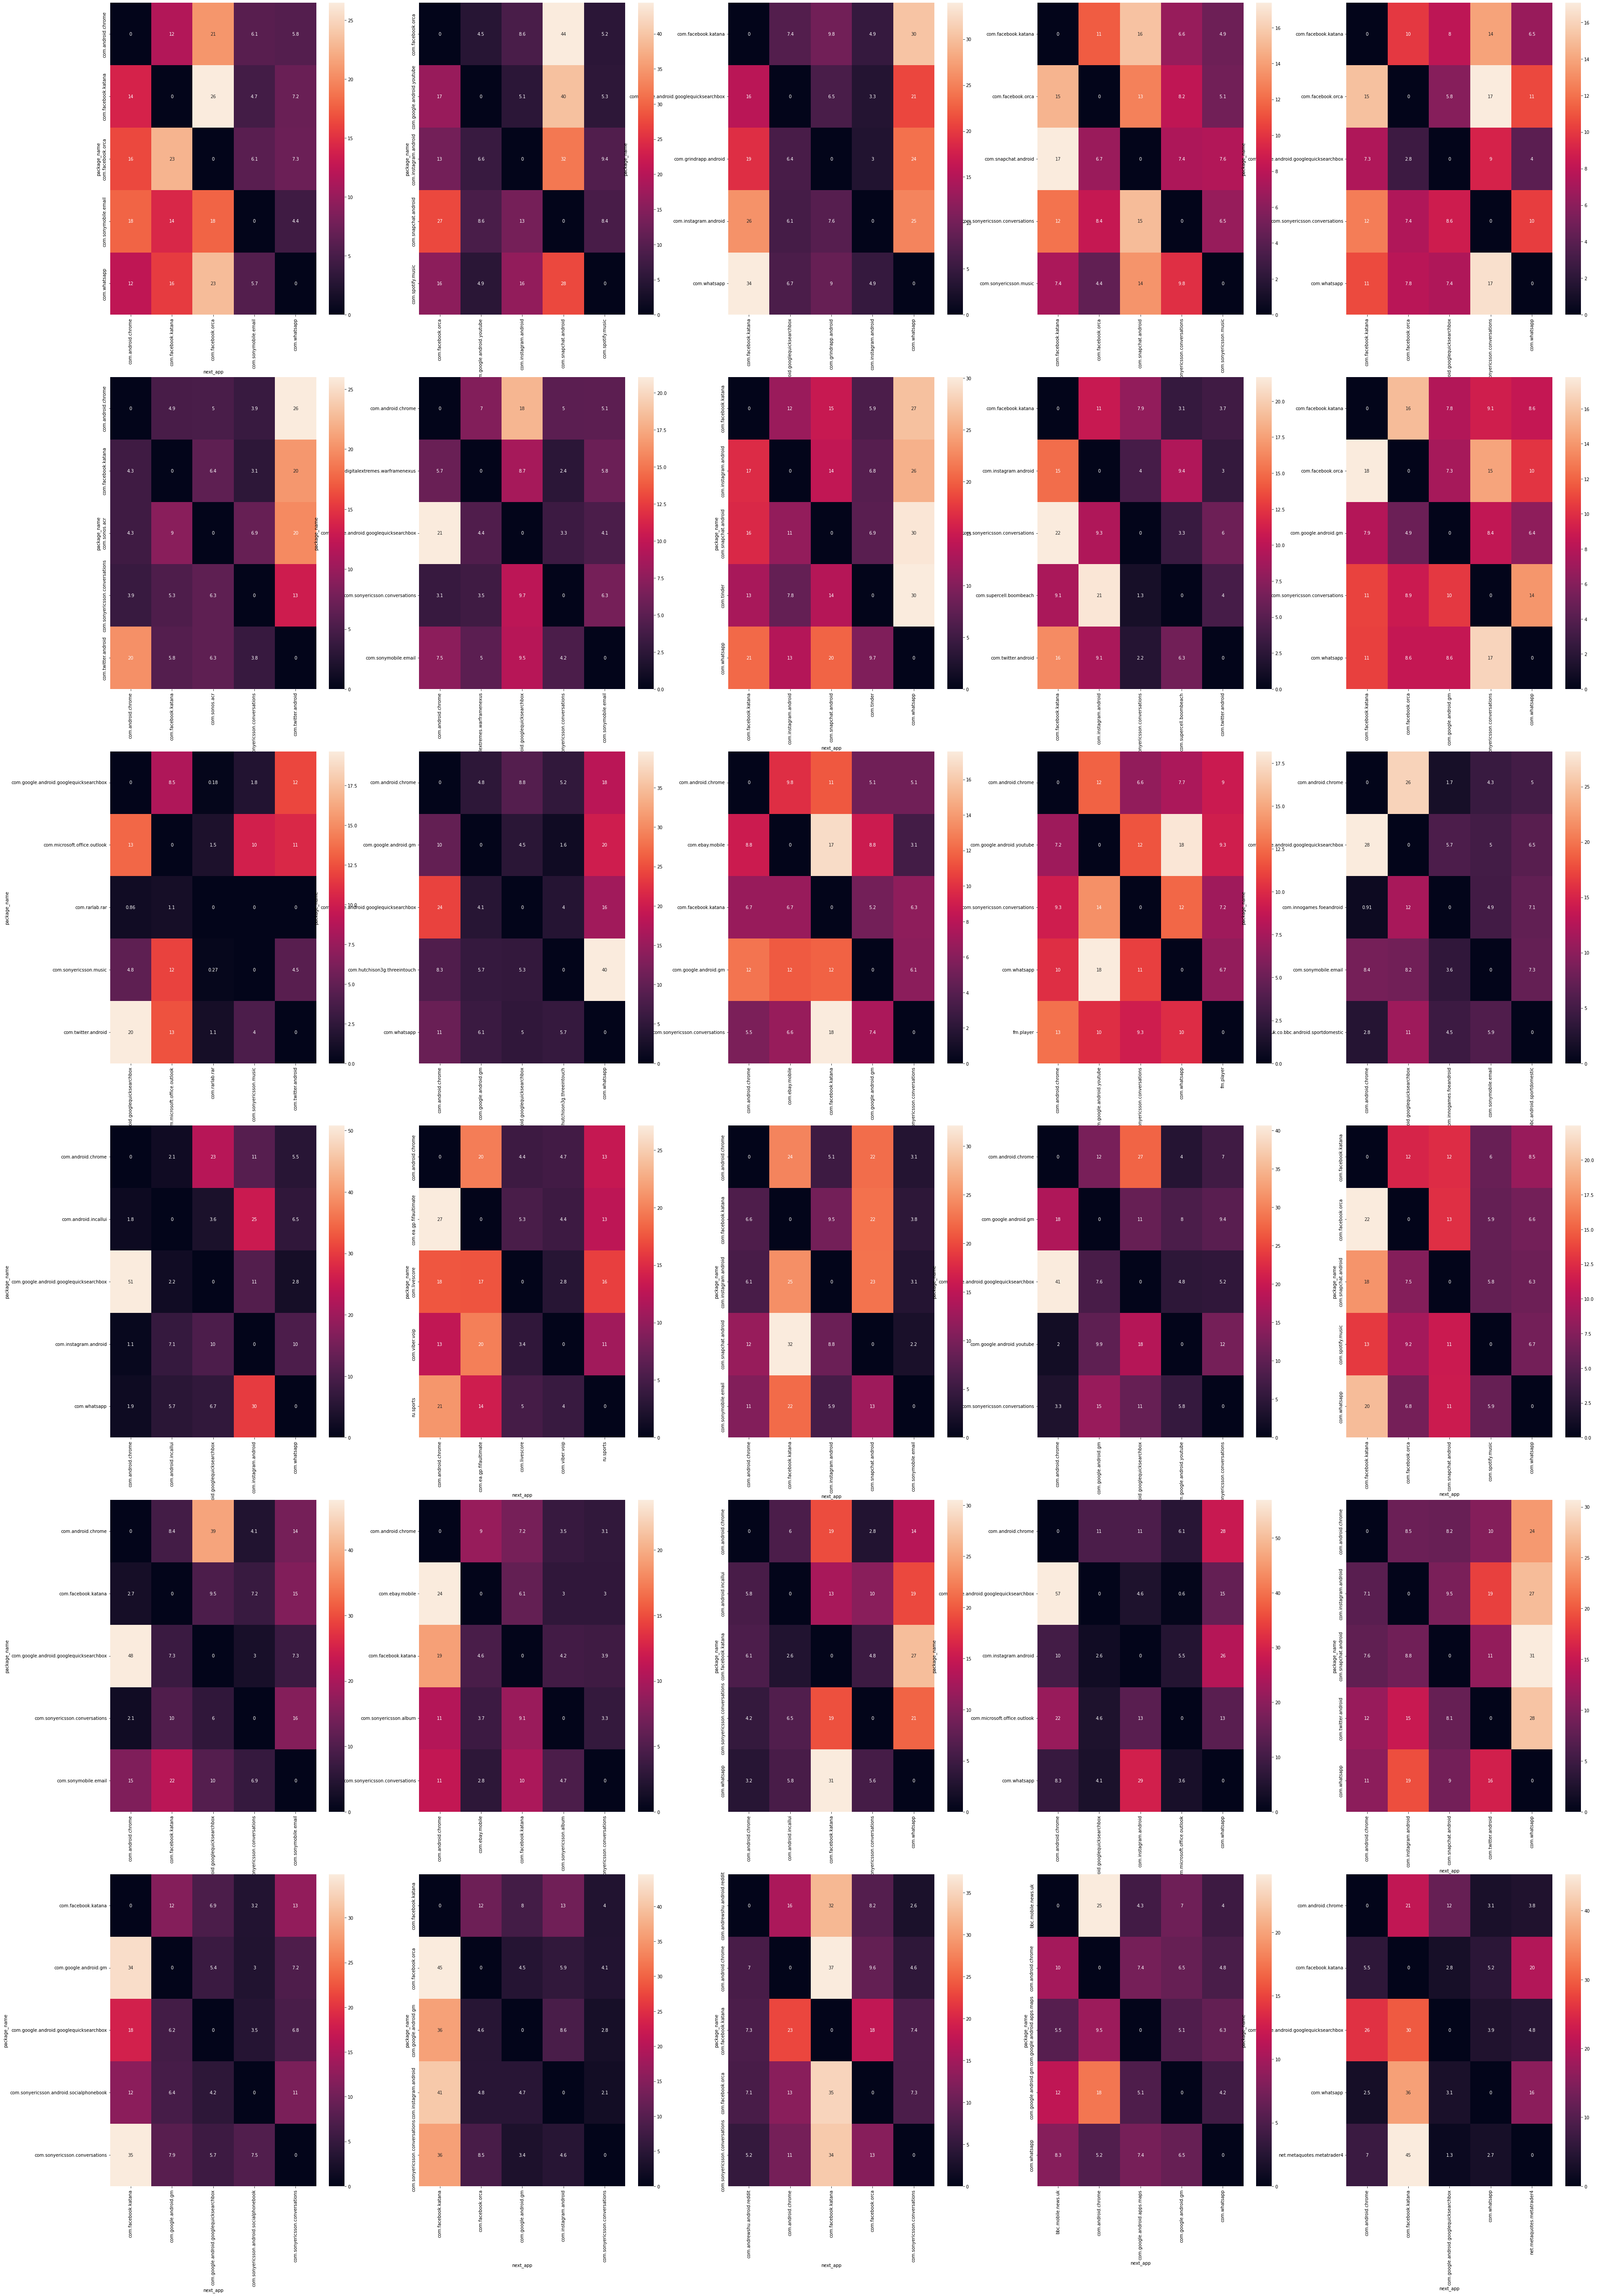

In [79]:
fig, axs = plt.subplots(6,5,figsize=(60,90))  
axs = axs.ravel()
for i in range(30):
    transitions_for_top_5=df_transition[(df_transition.package_name.isin(top_5_apps.get_group(users[i]).package_name))&(df_transition.next_app.isin(top_5_apps.get_group(users[i]).package_name))]  
    sns.heatmap(transitions_for_top_5[transitions_for_top_5.user_id==users[i]].pivot(index=['package_name'], columns="next_app", values="probability").fillna(0), annot=True,ax=axs[i])
plt.show()